In [1]:
import pandas as pd
import numpy as np
import copy

# Web scraper task
Here is the part where you modify the cells. Modify the range of pages in the first for loop, the keyword to signal comment extraction (if necessary), and the target language for translation (if necessary) 

In [2]:
import time
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

directory_of_chromedriver=r"C:\Users\celin\Documents\chromedriver.exe"

In [21]:
# Котлеты домашние из растительного мяса, Welldone, 180 г 491037254
# Котлеты для бургеров из растительного мяса, Welldone, 200 г 491165096
# Фарш из растительного мяса, Welldone, 400 г 491083590
# Котлеты растительные Hiburger для бургера Hi, 800 г 229186105
# Наггетсы растительные Hi - Higgets, замороженные, 200 г 317602877
# Филе растительное со вкусом говядины Hi 200г, 400 г 626538288
res = []
product_id = 626538288
for i in range(1,9):
    attempt_counter = 0
    result = False
    while attempt_counter < 5 and not result:
        try:
            driver = webdriver.Chrome(executable_path=directory_of_chromedriver)
            driver.get(f'https://www.ozon.ru/product/{product_id}/reviews?page={i}')
            
            review_elements = driver.find_elements(By.XPATH, '//div[@class="sq"]')
            rating_elements = driver.find_elements(By.XPATH, '//div[@class="e1-a6"]')
            
            for review, rating_element in zip(review_elements, rating_elements):
                review_text = review.text.splitlines()
                style_value = rating_element.get_attribute("style")
                rating = int(style_value.replace('width:', '').replace('%;', ''))/20   # Assuming 100% corresponds to 5 stars, 80% corresponds to 4 stars, etc.
                
                res.append((review_text, rating))
            
            driver.close()
            result = True
        except NoSuchElementException:
            print(f'Page {i}: Error N{attempt_counter+1}')
            attempt_counter += 1
            driver.close()
            
    if attempt_counter == 5:
        print(f'Error on page {i}')


C:\Users\celin\AppData\Local\Temp\ipykernel_18888\3279653217.py:14: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=directory_of_chromedriver)


In [ ]:
# Create a dictionary with product IDs as keys and brand names as values
brands = {491037254: 'Welldone', 
          491165096: 'Welldone', 
          491083590: 'Welldone', 
          229186105: 'Healthy Innovation', 
          317602877: 'Healthy Innovation', 
          626538288: 'Healthy Innovation'}

# Create a new column 'Brand' in your dataframe by applying a lambda function to each row
# Assume df is your dataframe and 'Product_ID' is the column with the product IDs
df['Brand'] = df['Product_ID'].apply(lambda x: brands[x] if x in brands else 'Unknown')


In [23]:
# copy data
data = res.copy() 

# extract information
data_extracted = []

for item in data:
    review = item[0]
    rating = item[1]
    
    try:
        name_index = review.index('Товар куплен на OZON') - 2
        name = review[name_index]
    except ValueError:
        date = None

    try:
        date_index = review.index('Товар куплен на OZON') - 1
        date = review[date_index]
    except ValueError:
        date = None

    try:
        advantages_index = review.index('Достоинства') + 1
        advantages = review[advantages_index]
    except ValueError:
        advantages = None
    
    try:
        disadvantages_index = review.index('Недостатки') + 1
        disadvantages = review[disadvantages_index]
    except ValueError:
        disadvantages = None
    
    try:
        comment_index = review.index('Комментарий') + 1
        comment = review[comment_index]
    except ValueError:
        comment = None
    
    data_extracted.append((product_id, name, date, advantages, disadvantages, comment, rating))


df = pd.DataFrame(data_extracted, columns=['product_id', 'name', 'date', 'advantages', 'disadvantages', 'comment', 'rating'])

print(df)


     product_id                                       name           date   
0     626538288                                  Венера К.  7 Апреля 2023  \
1     626538288                                   Мария Г.    24 Мая 2023   
2     626538288                                   Ирада А.    21 Мая 2023   
3     626538288  Пользователь предпочёл скрыть свои данные     2 Мая 2023   
4     626538288                                   Олеся П.  2 Апреля 2023   
..          ...                                        ...            ...   
160   626538288  Пользователь предпочёл скрыть свои данные   22 Июля 2022   
161   626538288                                 Виталий Г.   16 Июля 2022   
162   626538288                                 Виталий Г.   16 Июля 2022   
163   626538288  Пользователь предпочёл скрыть свои данные   16 Июля 2022   
164   626538288                               Анастасия Ц.   14 Июля 2022   

           advantages                                      disadvantages   

In [61]:
df.to_csv('combined_reviews.csv', mode='a', header=True, encoding='utf-8-sig')

In [48]:
#Alternative to translate comment, if the amount of request is too big
from yandexfreetranslate import YandexFreeTranslate
yt = YandexFreeTranslate(api = "ios")
chunk_size = 1000 # number of rows to translate per chunk

for i in range(0, len(df), chunk_size):
    start = i
    end = min(i + chunk_size, len(df))
    print(f"Translating rows {start+1} to {end}...")

    # translate the current chunk of rows
    df_test.loc[start:end, "advantages_en"] = df_test.loc[start:end, "advantages"].apply(lambda x: yt.translate('ru','en',
                x) if type(x) == str else x)

Translating rows 1 to 1000...


KeyboardInterrupt: 

# Sentiment analysis tasks

In [283]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

# Download the stop words and wordnet from NLTK
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize the text
    word_tokens = word_tokenize(text)

    # Lowercase each word in the text
    word_tokens = [word.lower() for word in word_tokens]

    # Remove punctuation and numbers
    word_tokens = [re.sub('[^a-zA-Z]', '', word) for word in word_tokens]

    # Lemmatize and remove stop words
    word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens if word not in stop_words and word != ""]

    return " ".join(word_tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\celin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [288]:
from tqdm import tqdm

# Then modify your apply calls like this:
tqdm.pandas()

# Apply the preprocessing function to your text data, handling missing values
df['advantages_processed'] = df['advantages'].fillna('').apply(preprocess_text)
df['disadvantages_processed'] = df['disadvantages'].fillna('').apply(preprocess_text)
df['comment_processed'] = df['comment'].fillna('').apply(preprocess_text)

In [290]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Concatenate all preprocessed reviews into one column
df['all_reviews_processed'] = df['advantages_processed'] + ' ' + df['disadvantages_processed'] + ' ' + df['comment_processed']

# Instantiate the vectorizer object
vectorizer = TfidfVectorizer()

# Fit and transform the text data
tfidf_matrix = vectorizer.fit_transform(df['all_reviews_processed'])

# This matrix can then be used for further analysis (sentiment analysis, topic modeling, etc.)


In [291]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Create a SentimentIntensityAnalyzer object
sid_obj = SentimentIntensityAnalyzer()

# Prepare columns for sentiment scores
df['vader_score'] = 0.0
df['textblob_score'] = 0.0

# Function to get sentiment score using VADER
def get_vader_score(text):
    sentiment_dict = sid_obj.polarity_scores(text)
    return sentiment_dict['compound']

# Function to get sentiment score using TextBlob
def get_textblob_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply the functions to the reviews
df['vader_score'] = df['all_reviews_processed'].apply(get_vader_score)
df['textblob_score'] = df['all_reviews_processed'].apply(get_textblob_score)


In [294]:
columns = ['advantages_processed','disadvantages_processed', 'comment_processed']
df = df.drop(columns=columns)

In [94]:
# Prepare the dataset for sentiment analysis (remove NaN)
df = pd.read_csv('combined_reviews_translated.csv')
df = df.drop(columns='Unnamed: 0')
df['advantages'] = df['advantages'].fillna('')
df['disadvantages'] = df['disadvantages'].fillna('')
df['comment'] = df['comment'].fillna('')


In [95]:
from transformers import pipeline
from tqdm import tqdm

# Get RoBERTa model
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
#If you get "The size of tensor a (707) must match the size of tensor b (512)" you need to change padding
#classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=None, truncation=True,max_length=50,add_special_tokens=True,padding=True)

# with pd.option_context('display.max_colwidth', None):
#   display(df.loc[1,:])

# Concatenate all preprocessed reviews into one column
df['all_reviews'] = df['advantages'] + ' ' + df['disadvantages'] + ' ' + df['comment']

# Initialize an empty list to store the results
sentiments = []

# Iterate over the reviews with a progress bar from tqdm
for review in tqdm(df['all_reviews']):
    try:
        # Classify the sentiment of the review and append it to our list
        sentiment = classifier(review)
        sentiments.append(sentiment)
    except Exception as e:
        # If there's any error, append a None to our list and print the error message
        sentiments.append(None)
        print(f"Error: {e}, at: {review}")

# Assign the list of sentiments to a new column in the dataframe
df["sentiments"] = sentiments

c:\Users\celin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 1030/1030 [00:36<00:00, 27.96it/s]


In [99]:
# Initialize the sentiment analysis pipeline
classifier = pipeline('text-classification', model='distilbert-base-uncased-finetuned-sst-2-english')

# Apply the pipeline to your data
sentiments = []
for review in tqdm(df['all_reviews']):
    try:
        sentiment = classifier(review, truncation=True, padding=True)[0]['label']
        sentiments.append(sentiment)
    except Exception as e:
        print(f"Error: {e} \nOn review: {review}")
        sentiments.append('ERROR')

df['BERT_sentiments'] = sentiments
df['BERT_sentiments'] = df['BERT_sentiments'].replace({'LABEL_0': 'Negative', 'LABEL_1': 'Neutral', 'LABEL_2': 'Positive'})

100%|██████████| 1030/1030 [00:32<00:00, 32.15it/s]


In [156]:
# Normalize json in 'BERT_emotions' into separate columns and add to the original dataframe
df_emotions = pd.json_normalize(df['BERT_emotions'].apply(lambda x: x[0]))

# Merge it with the original dataframe
df = pd.concat([df, df_emotions], axis=1)
# Function to extract emotions
def extract_emotions(emotion_list):
    # Flatten the list of dictionaries
    emotion_dict = {emotion['label']: emotion['score'] for emotion in emotion_list[0]}
    return pd.Series(emotion_dict)

# Apply the function to each row of 'BERT_emotions'
emotions_df = df['BERT_emotions'].apply(extract_emotions)

# Join the original DataFrame with the new DataFrame
df = df.join(emotions_df)

# Print a sample of the DataFrame
df.sample(5)

,product_id,brand,name,date,rating,advantages,disadvantages,comment,all_reviews,BERT_emotions,BERT_sentiments,0,1,2,3,4,5,6
116,491165096,Welldone,Вячеслав М.,27 Мая 2023,5.0,,,,,"[[{'label': 'anger', 'score': 0.09306240826845...",POSITIVE,"{'label': 'anger', 'score': 0.09306240826845169}","{'label': 'disgust', 'score': 0.04964156448841...","{'label': 'fear', 'score': 0.7082684636116028}","{'label': 'joy', 'score': 0.021410461515188217}","{'label': 'neutral', 'score': 0.04992206022143...","{'label': 'sadness', 'score': 0.07001827657222...","{'label': 'surprise', 'score': 0.0076767555437..."
498,229186105,Healthy Innovation,Андрей А.,21 Сентября 2022,5.0,,,,,"[[{'label': 'anger', 'score': 0.09306240826845...",POSITIVE,"{'label': 'anger', 'score': 0.09306240826845169}","{'label': 'disgust', 'score': 0.04964156448841...","{'label': 'fear', 'score': 0.7082684636116028}","{'label': 'joy', 'score': 0.021410461515188217}","{'label': 'neutral', 'score': 0.04992206022143...","{'label': 'sadness', 'score': 0.07001827657222...","{'label': 'surprise', 'score': 0.0076767555437..."
655,229186105,Healthy Innovation,Пользователь предпочёл скрыть свои данные,15 Марта 2022,5.0,,,,,"[[{'label': 'anger', 'score': 0.09306240826845...",POSITIVE,"{'label': 'anger', 'score': 0.09306240826845169}","{'label': 'disgust', 'score': 0.04964156448841...","{'label': 'fear', 'score': 0.7082684636116028}","{'label': 'joy', 'score': 0.021410461515188217}","{'label': 'neutral', 'score': 0.04992206022143...","{'label': 'sadness', 'score': 0.07001827657222...","{'label': 'surprise', 'score': 0.0076767555437..."
214,491083590,Welldone,Елена К.,16 Апреля 2023,5.0,,,,,"[[{'label': 'anger', 'score': 0.09306240826845...",POSITIVE,"{'label': 'anger', 'score': 0.09306240826845169}","{'label': 'disgust', 'score': 0.04964156448841...","{'label': 'fear', 'score': 0.7082684636116028}","{'label': 'joy', 'score': 0.021410461515188217}","{'label': 'neutral', 'score': 0.04992206022143...","{'label': 'sadness', 'score': 0.07001827657222...","{'label': 'surprise', 'score': 0.0076767555437..."
40,491037254,Welldone,Анна А.,26 Апреля 2023,5.0,,,,,"[[{'label': 'anger', 'score': 0.09306240826845...",POSITIVE,"{'label': 'anger', 'score': 0.09306240826845169}","{'label': 'disgust', 'score': 0.04964156448841...","{'label': 'fear', 'score': 0.7082684636116028}","{'label': 'joy', 'score': 0.021410461515188217}","{'label': 'neutral', 'score': 0.04992206022143...","{'label': 'sadness', 'score': 0.07001827657222...","{'label': 'surprise', 'score': 0.0076767555437..."


In [169]:
# Save DataFrame to .csv with UTF-8 encoding
df.to_csv('bert_reviews_final.csv', index=False, encoding='utf-8')
# Load DataFrame from .csv with UTF-8 encoding
df = pd.read_csv('bert_reviews_final.csv', encoding='utf-8')

# Exploratory Descriptive Statistics

In [455]:
#Manual verification of false positive, false negative and inaccurate emotion score (empty reviews)
df = pd.read_excel('abert_reviews_final.xlsx')
df.columns

Index(['product_id', 'brand', 'name', 'date', 'rating', 'advantages',
       'disadvantages', 'comment', 'all_reviews', 'BERT_emotions',
       'BERT_sentiments', 'anger', 'disgust', 'fear', 'joy', 'neutral',
       'sadness', 'surprise', 'all_reviews_processed', 'vader_score',
       'textblob_score', 'Unnamed: 21', 'Unnamed: 22'],
      dtype='object')

In [456]:
df_stat = df[['product_id', 'brand','rating', 'BERT_sentiments', 'anger', 'disgust', 'fear', 'joy', 'neutral','sadness', 'surprise', 'vader_score',
       'textblob_score']]
# Create a dataframe for the brand "Welldone"
df_welldone = df_stat[df_stat['brand'] == 'Welldone']
# Create a dataframe for the brand "Healthy Innovation"
df_hi = df_stat[df_stat['brand'] == 'Healthy Innovation']

In [457]:
table_stat = round(df_stat.describe(),2)

In [416]:
table_stat

,product_id,rating,anger,disgust,fear,joy,neutral,sadness,surprise,vader_score,textblob_score
count,6.730000e+02,673.00,645.00,645.00,645.00,645.00,667.00,645.00,643.00,673.00,673.00
mean,4.061729e+08,4.75,0.04,0.10,0.08,0.54,0.17,0.05,0.03,0.47,0.43
std,1.411767e+08,0.72,0.06,0.18,0.15,0.33,0.20,0.11,0.07,0.36,0.39
min,2.291861e+08,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.86,-1.00
25%,2.291861e+08,5.00,0.01,0.01,0.01,0.19,0.03,0.01,0.01,0.15,0.00
50%,4.910373e+08,5.00,0.02,0.03,0.02,0.70,0.08,0.01,0.01,0.57,0.40
75%,4.911651e+08,5.00,0.04,0.08,0.08,0.80,0.20,0.04,0.02,0.76,0.75
max,6.265383e+08,5.00,0.69,0.98,0.97,0.98,0.93,0.89,0.92,0.98,1.00


In [406]:
import pandas as pd

def compute_summary_statistics(df_name):
    df = globals()[df_name]  # Access the dataframe using its name
    
    # Calculate the summary statistics
    rating_mean = round(df['rating'].mean(), 2)
    rating_std = round(df['rating'].std(), 2)
    vader_mean = round(df['vader_score'].mean(), 2)
    vader_std = round(df['vader_score'].std(), 2)
    textblob_mean = round(df['textblob_score'].mean(), 2)
    textblob_std = round(df['textblob_score'].std(), 2)
    
    # Create the summary statistics dataframe
    summary_stats = pd.DataFrame({
        'Statistic': ['Mean', 'Standard Deviation'],
        'Rating': [rating_mean, rating_std],
        'VADER Score': [vader_mean, vader_std],
        'TextBlob Score': [textblob_mean, textblob_std]
    })
    
    return summary_stats

# Example usage:
df_name = 'df_welldone'
summary_statistics = compute_summary_statistics(df_name)
print(summary_statistics)
df_name = 'df_hi'
summary_statistics = compute_summary_statistics(df_name)
print(summary_statistics)
df_name = 'df'
summary_statistics = compute_summary_statistics(df_name)
print(summary_statistics)

            Statistic  Rating  VADER Score  TextBlob Score
0                Mean    4.80         0.43            0.47
1  Standard Deviation    0.62         0.35            0.41
            Statistic  Rating  VADER Score  TextBlob Score
0                Mean    4.71         0.50            0.41
1  Standard Deviation    0.79         0.36            0.38
            Statistic  Rating  VADER Score  TextBlob Score
0                Mean    4.75         0.47            0.43
1  Standard Deviation    0.72         0.36            0.39


In [413]:
print(table_stat)

         product_id  rating   anger  disgust    fear     joy  neutral   
count  6.730000e+02  673.00  645.00   645.00  645.00  645.00   667.00  \
mean   4.061729e+08    4.75    0.04     0.10    0.08    0.54     0.17   
std    1.411767e+08    0.72    0.06     0.18    0.15    0.33     0.20   
min    2.291861e+08    1.00    0.00     0.00    0.00    0.00     0.00   
25%    2.291861e+08    5.00    0.01     0.01    0.01    0.19     0.03   
50%    4.910373e+08    5.00    0.02     0.03    0.02    0.70     0.08   
75%    4.911651e+08    5.00    0.04     0.08    0.08    0.80     0.20   
max    6.265383e+08    5.00    0.69     0.98    0.97    0.98     0.93   

       sadness  surprise  vader_score  textblob_score  
count   645.00    643.00       673.00          673.00  
mean      0.05      0.03         0.47            0.43  
std       0.11      0.07         0.36            0.39  
min       0.00      0.00        -0.86           -1.00  
25%       0.01      0.01         0.15            0.00  
50%   

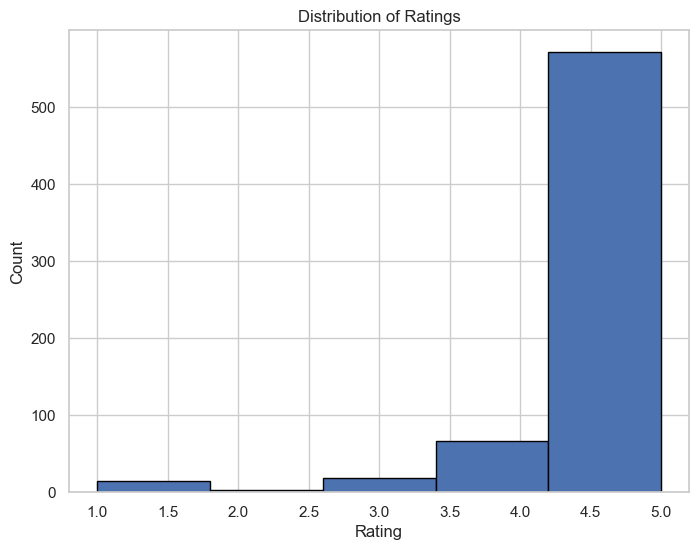

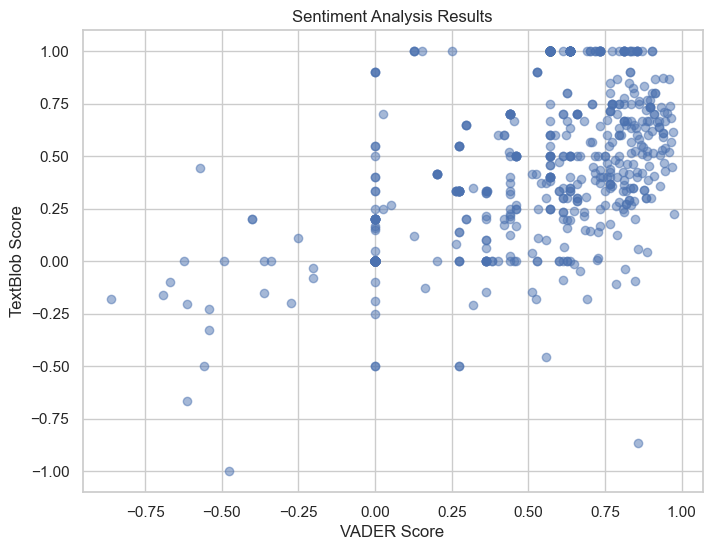

In [407]:
import matplotlib.pyplot as plt

# Figure 1: Distribution of Ratings
plt.figure(figsize=(8, 6))
plt.hist(df['rating'], bins=5, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.savefig('ratings_histogram.png')
plt.show()

# Figure 2: Sentiment Analysis Results
plt.figure(figsize=(8, 6))
plt.scatter(df['vader_score'], df['textblob_score'], alpha=0.5)
plt.xlabel('VADER Score')
plt.ylabel('TextBlob Score')
plt.title('Sentiment Analysis Results')
plt.savefig('sentiment_scatterplot.png')
plt.show()


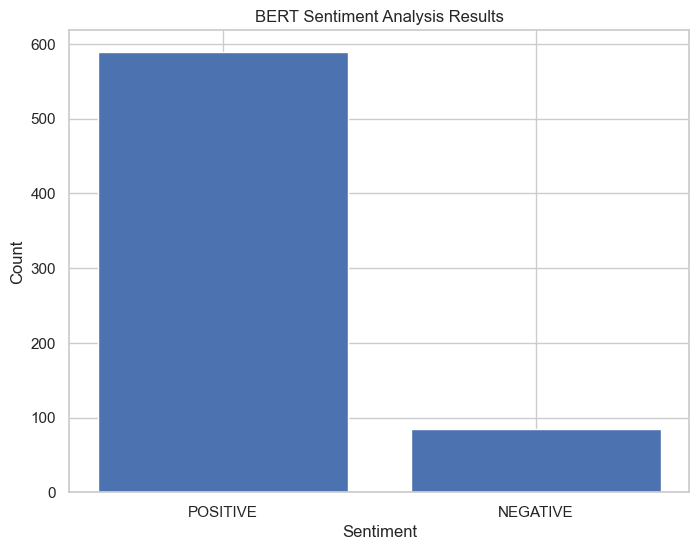

In [458]:
import matplotlib.pyplot as plt

# Calculate the count of positive and negative sentiments
sentiment_counts = df['BERT_sentiments'].value_counts()

# Figure 3: BERT Sentiment Analysis Results
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('BERT Sentiment Analysis Results')
plt.savefig('bert_sentiment_barplot.png')
plt.show()

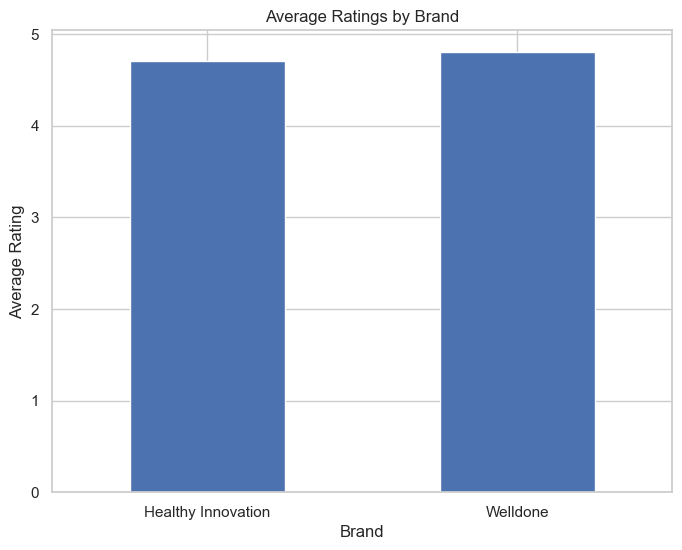

In [459]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
df.groupby('brand')['rating'].mean().plot(kind='bar')
plt.xlabel('Brand')
plt.ylabel('Average Rating')
plt.title('Average Ratings by Brand')
plt.xticks(rotation=0)
plt.show()


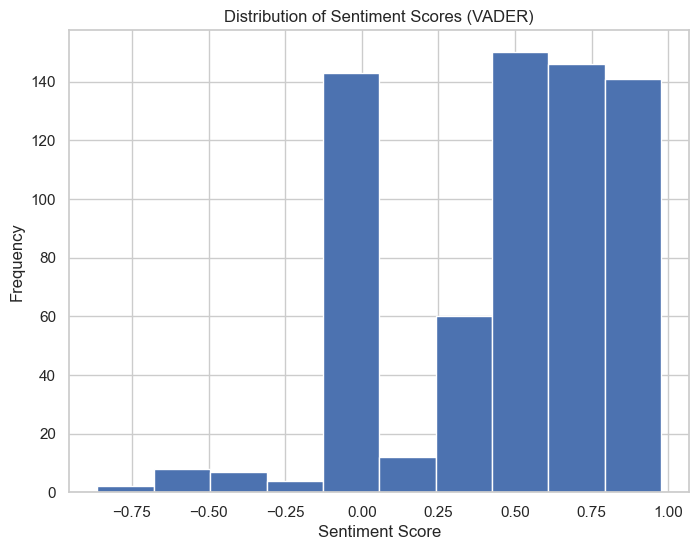

In [460]:
plt.figure(figsize=(8, 6))
df['vader_score'].plot(kind='hist', bins=10)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores (VADER)')
plt.show()


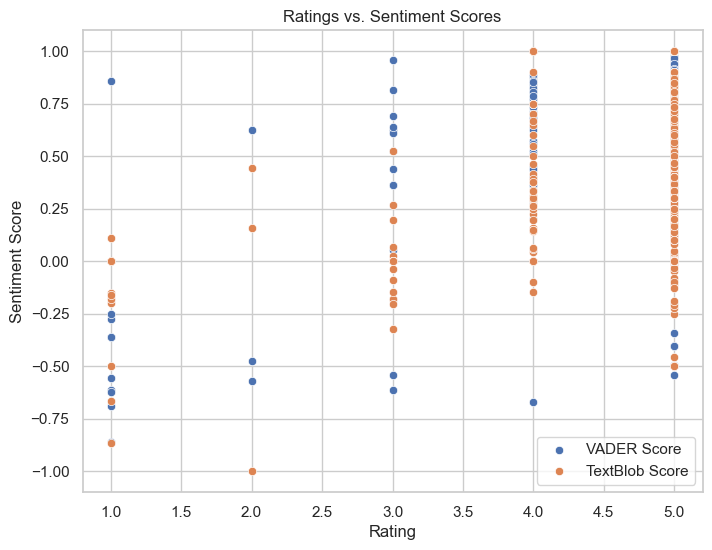

In [461]:
import seaborn as sns

plt.figure(figsize=(8, 6))

# Use Seaborn's scatterplot function
sns.scatterplot(data=df, x='rating', y='vader_score', label='VADER Score')
sns.scatterplot(data=df, x='rating', y='textblob_score', label='TextBlob Score')

plt.xlabel('Rating')
plt.ylabel('Sentiment Score')
plt.title('Ratings vs. Sentiment Scores')
plt.legend()

plt.show()


<Figure size 1000x600 with 0 Axes>

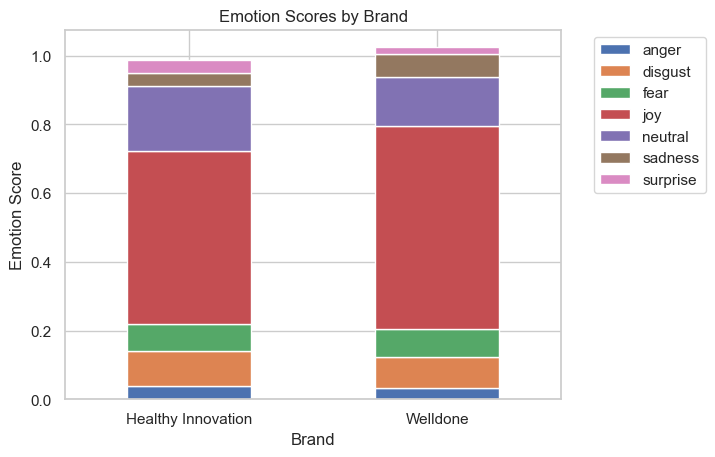

In [462]:
emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
df_emotions = df[emotions + ['brand']]

plt.figure(figsize=(10, 6))
df_emotions.groupby('brand')[emotions].mean().plot(kind='bar', stacked=True)
plt.xlabel('Brand')
plt.ylabel('Emotion Score')
plt.title('Emotion Scores by Brand')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [440]:
df_stat = df_stat.drop(columns="brand")

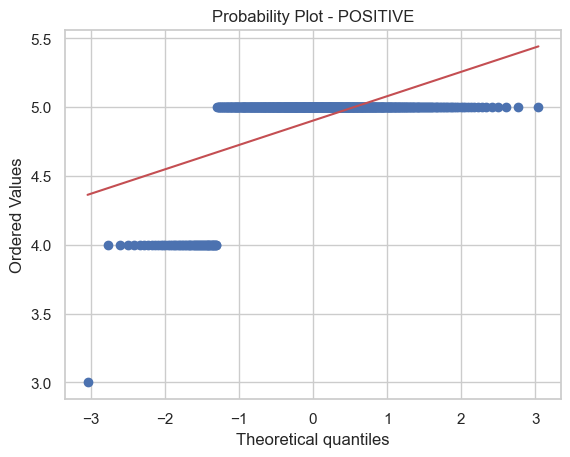

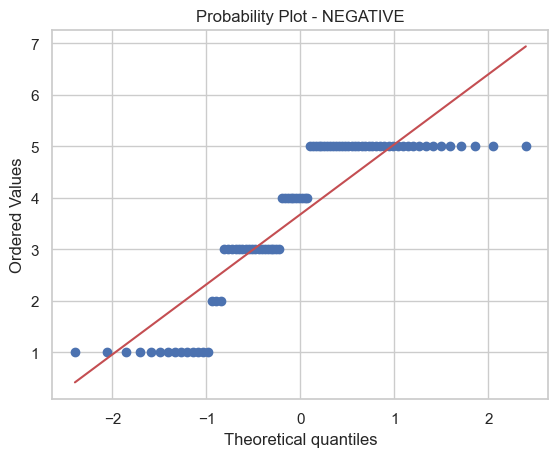

                        sum_sq     df           F        PR(>F)
C(BERT_sentiments)  109.951611    1.0  306.626967  7.963493e-57
Residual            240.610053  671.0         NaN           NaN
4.930904590327688
ANOVA BERT Sentiments
                             SS   df          MS           F P-value    F crit
Source of Variation                                                           
Between Groups       109.951611    1  109.951611  306.626967     0.0  5.046511
Within Groups        240.610053  671    0.358584                              
Total                350.561664  672    0.521669                              


In [448]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Probability Plot
unique_sentiments = df_stat['BERT_sentiments'].unique()
for sentiment in unique_sentiments:
    stats.probplot(df_stat[df_stat['BERT_sentiments'] == sentiment]['rating'], dist="norm", plot=plt)
    plt.title("Probability Plot - " + sentiment)
    plt.show()

# Model and ANOVA Table
model = ols('rating ~ C(BERT_sentiments)', data=df_stat).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Ratios
ratio1 = df_stat.groupby('BERT_sentiments')['rating'].std().max() / df_stat.groupby('BERT_sentiments')['rating'].std().min()
print(ratio1)

# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']]
anova_table = pd.DataFrame(data, columns=['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit'])
anova_table.set_index('Source of Variation', inplace=True)

# Calculate SSTR and update ANOVA table
x_bar = df_stat['rating'].mean()
SSTR = df_stat.groupby('BERT_sentiments').count() * (df_stat.groupby('BERT_sentiments').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['rating'].sum()

# Calculate SSE and update ANOVA table
SSE = (df_stat.groupby('BERT_sentiments').count() - 1) * df_stat.groupby('BERT_sentiments').var()
anova_table['SS']['Within Groups'] = SSE['rating'].sum()

# Calculate SSTR and update ANOVA table
SSTR = SSTR['rating'].sum() + SSE['rating'].sum()
anova_table['SS']['Total'] = SSTR

# Update degree of freedom
anova_table['df']['Between Groups'] = df_stat['BERT_sentiments'].nunique() - 1
anova_table['df']['Within Groups'] = df_stat.shape[0] - df_stat['BERT_sentiments'].nunique()
anova_table['df']['Total'] = df_stat.shape[0] - 1

# Calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# Calculate F
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# Calculate p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Calculate F critical
alpha = 0.05
tail_hypothesis_type = "two-tailed"  # possible types: "right-tailed", "left-tailed", "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1 - alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
print("ANOVA BERT Sentiments")
print(anova_table)


In [443]:
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['F']['Between Groups'] > anova_table['F crit']['Between Groups']:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and critical value is:", anova_table['F crit']['Between Groups'])
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 306.62696690171845  and p value is: 1.1102230246251565e-16
Null Hypothesis is rejected.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
F-score is: 306.62696690171845  and critical value is: 5.046511311372101
Null Hypothesis is rejected.


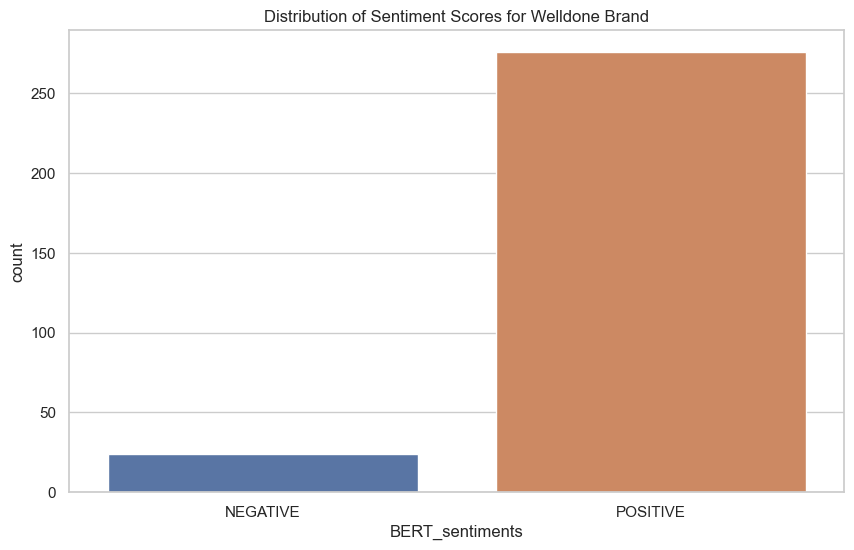

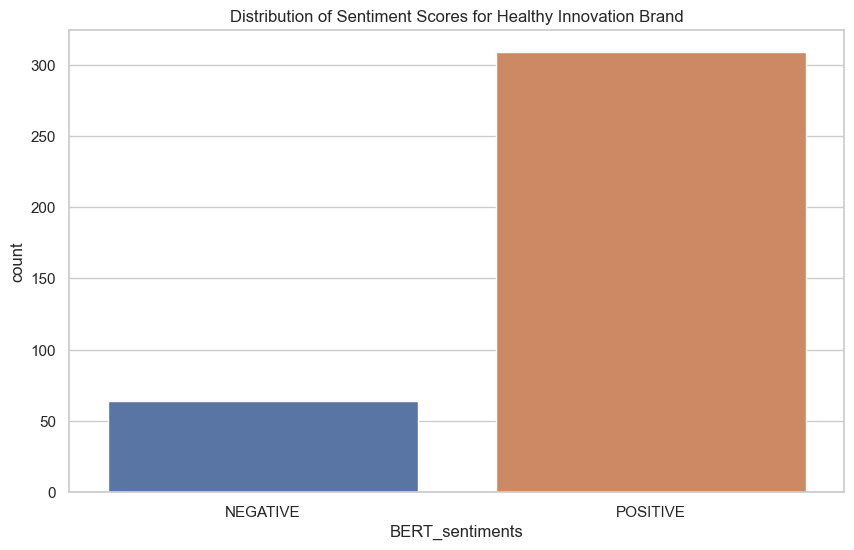

In [303]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Plotting for 'Welldone' brand
plt.figure(figsize=(10,6))
sns.countplot(x='BERT_sentiments', data=df_welldone)
plt.title('Distribution of Sentiment Scores for Welldone Brand')
plt.show()

# Plotting for 'Healthy Innovation' brand
plt.figure(figsize=(10,6))
sns.countplot(x='BERT_sentiments', data=df_hi)
plt.title('Distribution of Sentiment Scores for Healthy Innovation Brand')
plt.show()


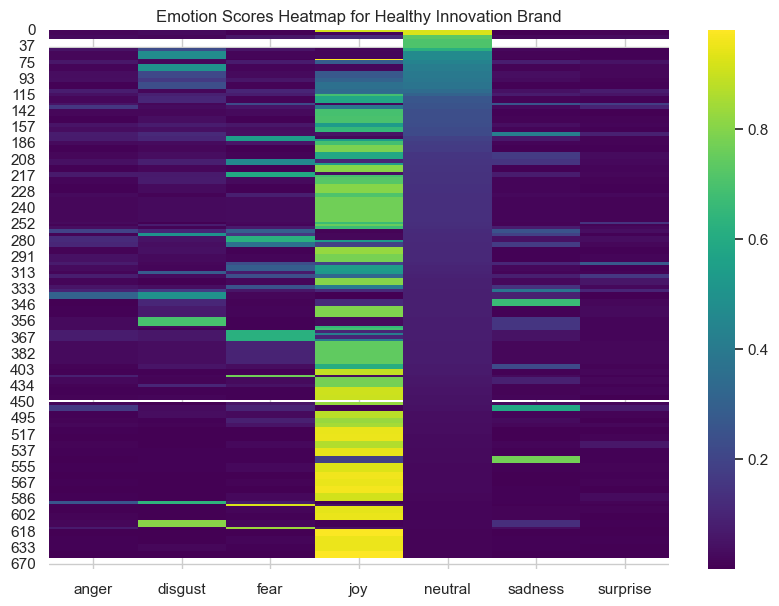

In [472]:
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(df_welldone[[ 'anger', 'disgust', 'fear', 'joy','neutral', 'sadness', 'surprise']], cmap='viridis')
plt.title('Emotion Scores Heatmap for Healthy Innovation Brand')
plt.show()

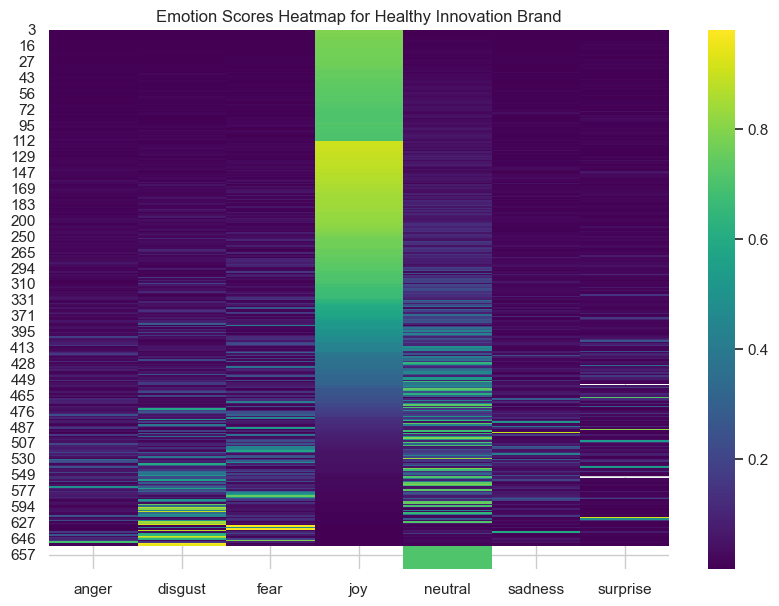

In [473]:
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(df_hi[[ 'anger', 'disgust', 'fear', 'joy','neutral', 'sadness', 'surprise']], cmap='viridis')
plt.title('Emotion Scores Heatmap for Healthy Innovation Brand')
plt.show()

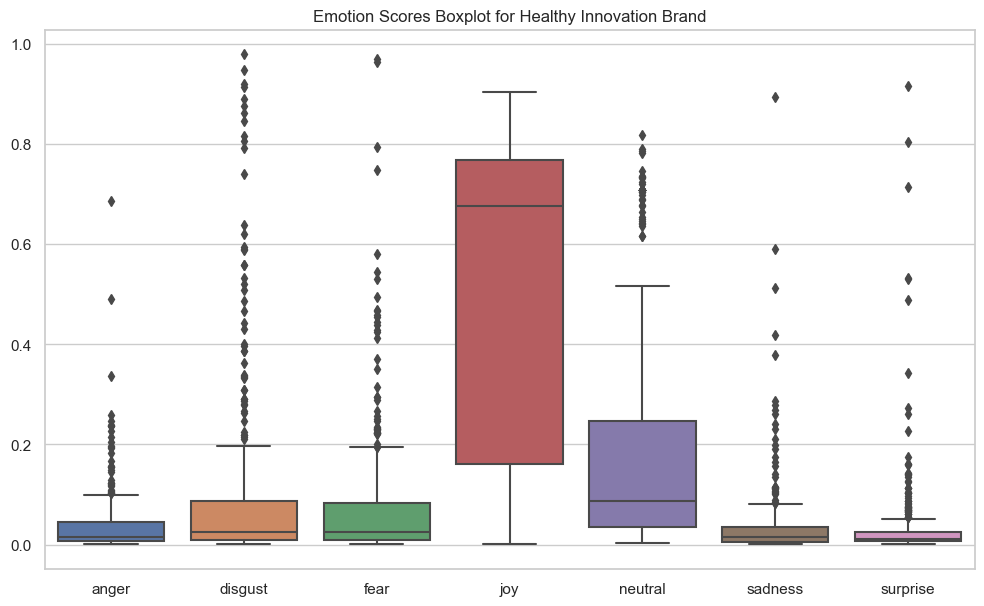

In [474]:
plt.figure(figsize=(12,7))
sns.boxplot(data=df_hi[['anger', 'disgust', 'fear', 'joy','neutral', 'sadness', 'surprise']])
plt.title('Emotion Scores Boxplot for Healthy Innovation Brand')
plt.show()

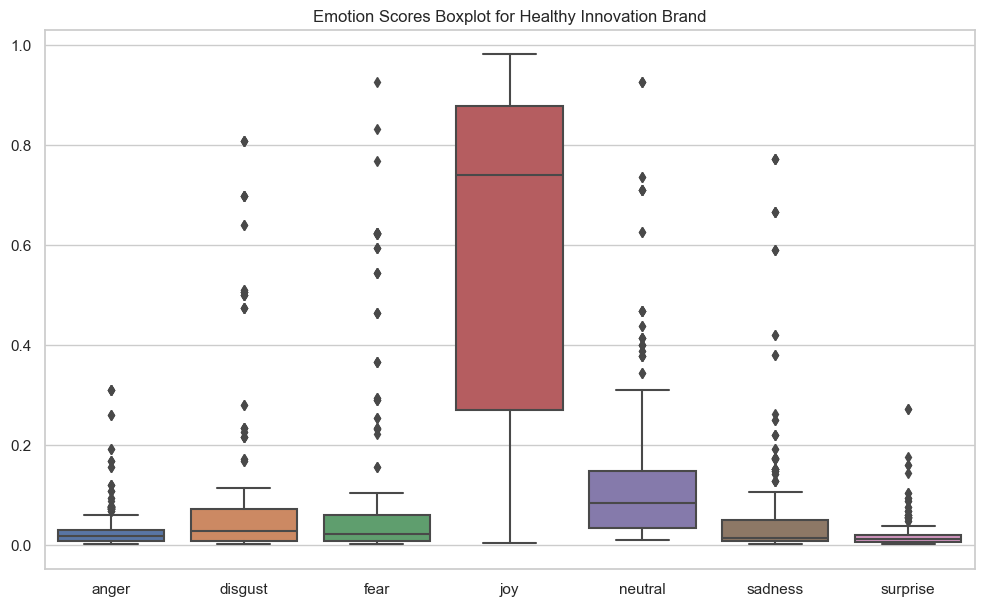

In [475]:
plt.figure(figsize=(12,7))
sns.boxplot(data=df_welldone[['anger', 'disgust', 'fear', 'joy','neutral', 'sadness', 'surprise']])
plt.title('Emotion Scores Boxplot for Healthy Innovation Brand')
plt.show()

array([[<Axes: title={'center': 'anger'}>,
        <Axes: title={'center': 'disgust'}>,
        <Axes: title={'center': 'fear'}>],
       [<Axes: title={'center': 'joy'}>,
        <Axes: title={'center': 'neutral'}>,
        <Axes: title={'center': 'sadness'}>],
       [<Axes: title={'center': 'surprise'}>, <Axes: >, <Axes: >]],
      dtype=object)

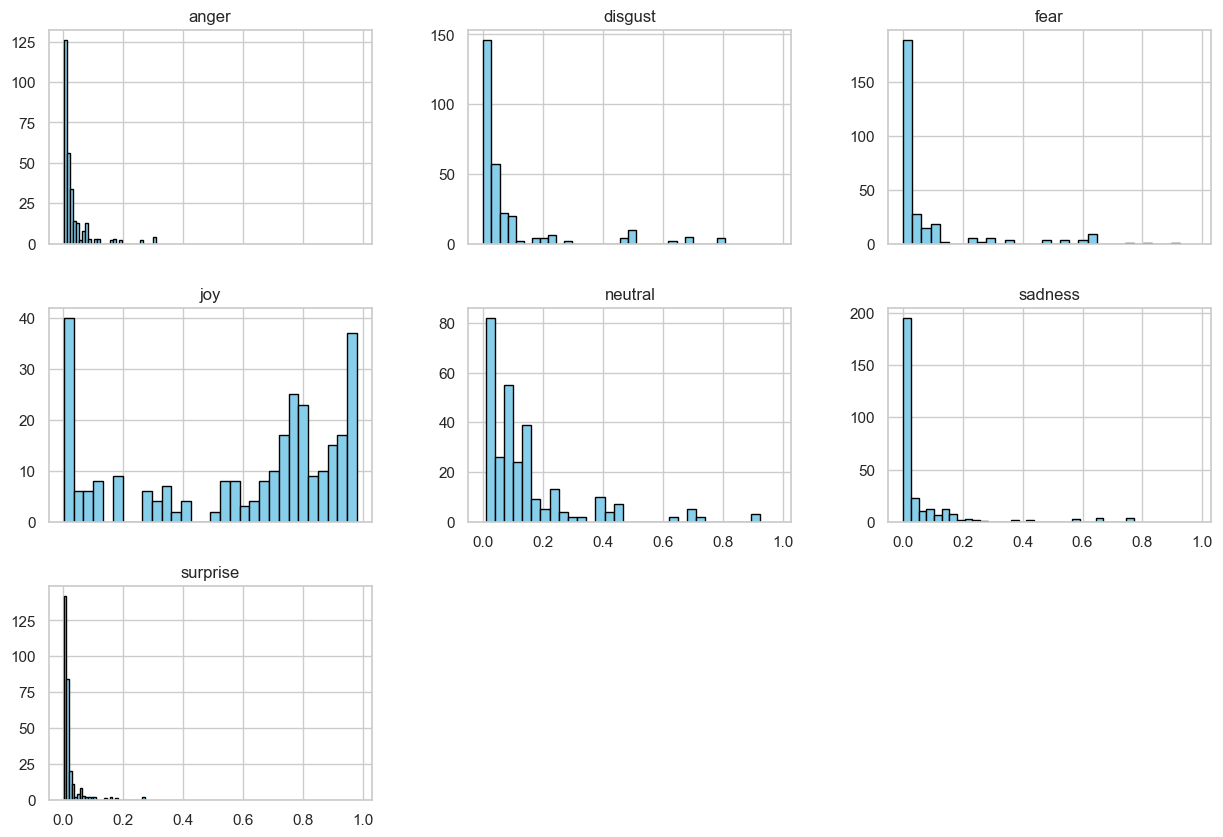

In [476]:
df_welldone[['anger', 'disgust', 'fear', 'joy','neutral', 'sadness', 'surprise']].hist(bins=30, figsize=(15, 10), layout=(3, 3), sharex=True, color='skyblue', edgecolor='black')

array([[<Axes: title={'center': 'anger'}>,
        <Axes: title={'center': 'disgust'}>,
        <Axes: title={'center': 'fear'}>],
       [<Axes: title={'center': 'joy'}>,
        <Axes: title={'center': 'neutral'}>,
        <Axes: title={'center': 'sadness'}>],
       [<Axes: title={'center': 'surprise'}>, <Axes: >, <Axes: >]],
      dtype=object)

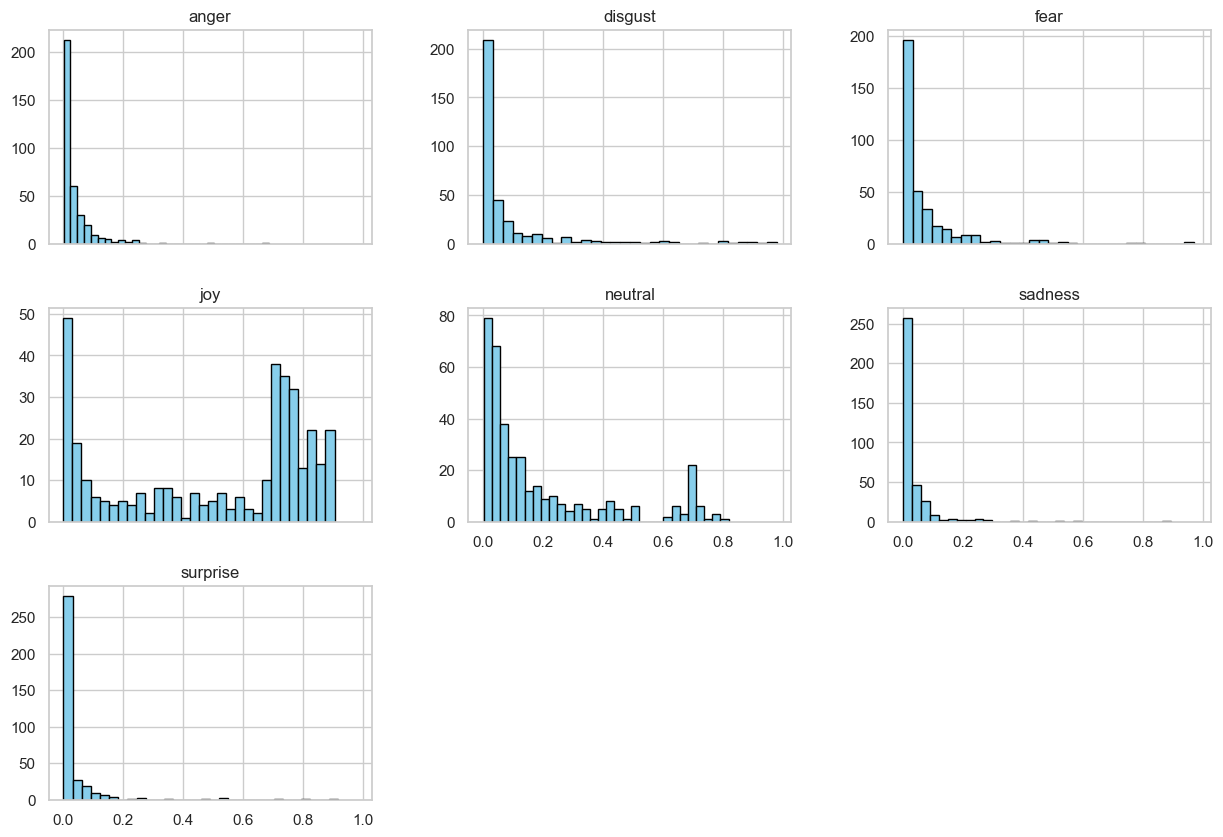

In [477]:
df_hi[['anger', 'disgust', 'fear', 'joy','neutral', 'sadness', 'surprise']].hist(bins=30, figsize=(15, 10), layout=(3, 3), sharex=True, color='skyblue', edgecolor='black')

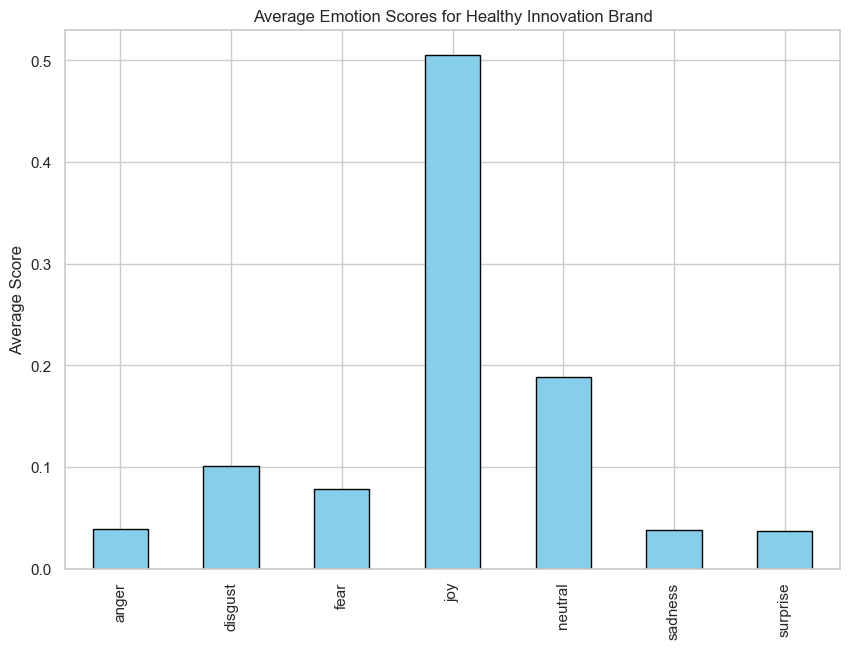

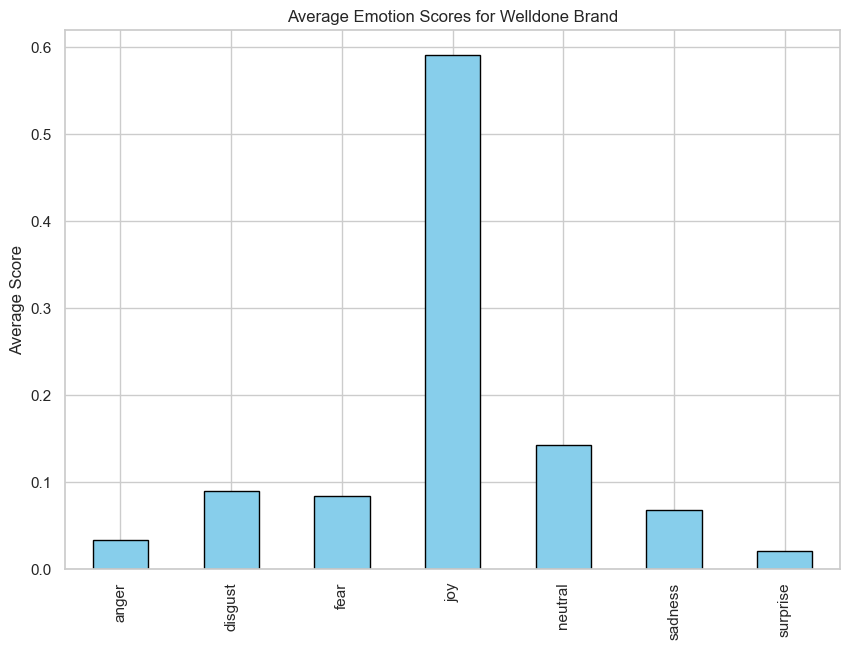

In [478]:
plt.figure(figsize=(10,7))
df_hi[['anger', 'disgust', 'fear', 'joy','neutral', 'sadness', 'surprise']].mean().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Emotion Scores for Healthy Innovation Brand')
plt.ylabel('Average Score')
plt.show()

plt.figure(figsize=(10,7))
df_welldone[['anger', 'disgust', 'fear', 'joy','neutral', 'sadness', 'surprise']].mean().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Emotion Scores for Welldone Brand')
plt.ylabel('Average Score')
plt.show()

In [479]:
# Import the word cloud function  
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [480]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Creating a text variable with all reviews
text = " ".join(review for review in df.all_reviews_processed)

# Creating a list of stopwords
stopwords = set(STOPWORDS)

# Generating the word cloud
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)


# Displaying the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

TypeError: sequence item 33: expected str instance, float found

In [ ]:
import nltk
from nltk.corpus import stopwords
from gensim import corpora
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Download stopwords from NLTK
nltk.download('stopwords')

# Get the stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from the text
text_without_stopwords = [word for word in text.split() if word.lower() not in stop_words]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import nltk
from nltk.corpus import stopwords
from gensim import corpora
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Download stopwords from NLTK
nltk.download('stopwords')

# Get the stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from the text
text_without_stopwords = [word for word in text.split() if word.lower() not in stop_words]

# Create the dictionary and corpus for LDA
dictionary = corpora.Dictionary([text_without_stopwords])
corpus = [dictionary.doc2bow(text_without_stopwords)]

# Run LDA
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary)

# Create the LDA visualization
lda_visualization = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(lda_visualization)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()

# Prepare the visualization
# `sort_topics=False` preserves the topic order in the LDA model.
vis = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Show the visualization
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.017094 -0.008669       1        1  22.301999
1      0.080600  0.103976       2        1   4.584456
2      0.091422 -0.039864       3        1   5.189993
3     -0.007167 -0.029736       4        1   3.942905
4      0.037324 -0.014022       5        1  12.644494
5     -0.046455 -0.029749       6        1   6.287388
6      0.006808  0.020389       7        1  18.709273
7     -0.104171  0.104844       8        1   5.532068
8      0.021427 -0.044456       9        1  15.120700
9     -0.096882 -0.062713      10        1   5.686724, topic_info=         Term        Freq       Total Category  logprob  loglift
22       very   80.000000   80.000000  Default  30.0000  30.0000
30         to  128.000000  128.000000  Default  29.0000  29.0000
59      tasty   61.000000   61.000000  Default  28.0000  28.0000
32          I  213.000000  213.000000  Default  27.0000  27.0000
26  delicious   68.000000   68.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
30         to    6.390661  128.038621  Topic10  -3.7802  -0.1305
33        and    6.607227  154.844884  Topic10  -3.7469  -0.2872
0           a    7.047780  208.461150  Topic10  -3.6823  -0.5200
7          in    3.942422  117.160284  Topic10  -4.2632  -0.5247
12        not    3.812301  110.133927  Topic10  -4.2968  -0.4964

[477 rows x 6 columns], token_table=      Topic      Freq Term
term                      
56        1  0.137343    -
56        2  0.068672    -
56        4  0.068672    -
56        5  0.343358    -
56        6  0.068672    -
...     ...       ...  ...
77        6  0.038733  you
77        7  0.116198  you
77        8  0.077465  you
77        9  0.058099  you
77       10  0.116198  you

[944 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])